**CelebA: DCGAN for generating faces**

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
from matplotlib import pyplot as plt

WIDTH = 128
HEIGHT = 128

from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

Generator and Discriminator

In [10]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.6)(x)
    
    x = Dense(1, activation='relu')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=1e-5,
        clipvalue=1.0,
        decay=1e-7
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=1e-5, clipvalue=1.0, decay=1e-7)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

# load pretrained weights (see part 1 of this kernel)
gan.load_weights('/content/drive/My Drive/faces_gan.h5')

modification 1: change activation from 'sigmiod' to 'relu', dropout from 0.4 to 0.6

modification 2: change 2 optimizers ('lr' from .0001 to 1e-5, 'decay' from 1e-8 to 1e-7)

modification 3: change SHIFTS from [-2, -1, -.5, -.2, -.1, 0, .1, .2, .5, 1, 2] to [-1, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, 1]

In [11]:
EXPLORE_FEATURES = 32
SHIFTS = [-1, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, 1]

# visualize possible tunings for defining features meaning in latent vector
plt.figure(1, figsize=(2 * len(SHIFTS), EXPLORE_FEATURES * 2))
i = 0
for f_pos in range(EXPLORE_FEATURES):
    for shift in SHIFTS:
        i += 1
        plt.subplot(EXPLORE_FEATURES, len(SHIFTS), i)
        latent_vector = np.zeros((1, LATENT_DIM))
        latent_vector[0, f_pos] = shift
        img = generator.predict(latent_vector)[0]
        plt.imshow(img)
        plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

modification 4: change SHIFTS from [-1, -.7, -.4, -.2, 0, .2, .4, .7, 1] to [-1, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, 1]

modification 5: figsize from (18,2) to (22,2) and subplot from (1,9) to (1,11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

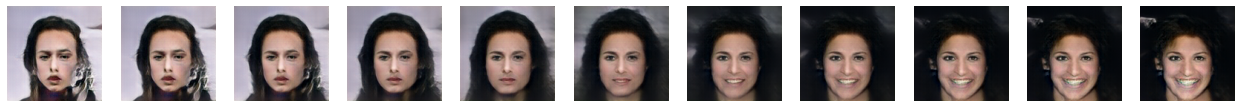

In [12]:
def create_latent_vector(smile=0, thickness=0, male=0, light_hair=0, short_hair=0):
    vec = np.zeros((1, LATENT_DIM))
    
    # forw is a list of features with accelerating effect
    # back is a list of features with descelerating effect
    def fill_vec(forw, back, coef):
        vec = np.zeros((LATENT_DIM, ))
        for pos in forw:
            vec[pos] = 1
        for pos in back:
            vec[pos] = -1
        vec *= coef
        return vec
    
    vec[0] += fill_vec([1, 3, 6], [7, 9, 14, 23, 28, 29, 30], smile)
    vec[0] += fill_vec([5, 8, 10, 15, 20], [9, 22, 23, 24], thickness)
    vec[0] += fill_vec([2, 5, 17, 30], [0, 1, 12, 18, 25, 28], male)
    vec[0] += fill_vec([2, 12], [13, 31], light_hair)
    vec[0] += fill_vec([2, 5], [0, 6, 18, 20], short_hair)
    
    # we can see that some feature may correlate
    
    return vec
    
    vec[0] += fill_vec([1, 3, 6], [7, 9, 14, 23, 28, 29, 30], smile)
    vec[0] += fill_vec([5, 8, 10, 15, 20], [9, 22, 23, 24], thickness)
    vec[0] += fill_vec([2, 5, 17, 30], [0, 1, 12, 18, 25, 28], male)
    vec[0] += fill_vec([2, 12], [13, 31], light_hair)
    vec[0] += fill_vec([2, 5], [0, 6, 18, 20], short_hair)
    
    # we can see that some feature may correlate
    
    return vec

def plot_images(vectors):
    plt.figure(1, figsize=(22, 2))
    i = 0
    for vec in vectors:
        i += 1
        plt.subplot(1, 11, i)
        img = generator.predict(vec)[0]
        plt.imshow(img)
        plt.axis('off')
    plt.show()

SHIFTS = [-1, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, 1]

# over smiles
plot_images([create_latent_vector(smile=shift) for shift in SHIFTS])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

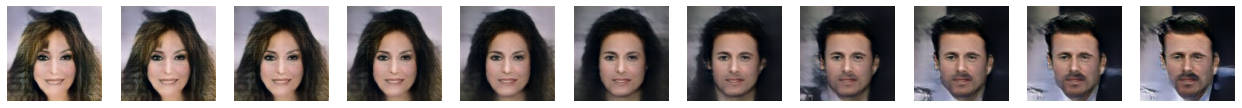

In [13]:
# over gender
plot_images([create_latent_vector(male=shift) for shift in SHIFTS])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

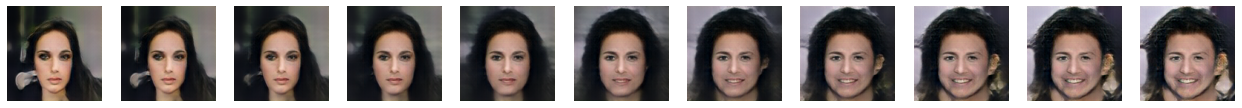

In [14]:
# over thickness
plot_images([create_latent_vector(thickness=shift) for shift in SHIFTS])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

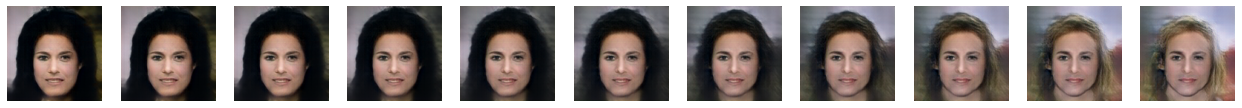

In [15]:
# over light_hair
plot_images([create_latent_vector(light_hair=shift) for shift in SHIFTS])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

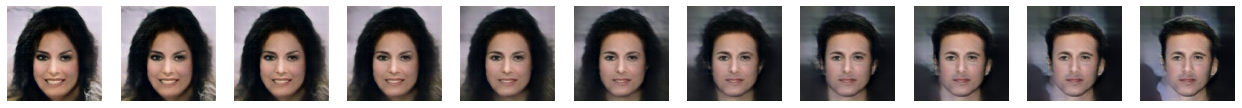

In [16]:
# over short_hair
plot_images([create_latent_vector(short_hair=shift) for shift in SHIFTS])

modification 6: add some examples in different types

modification 7: rearrange comparisions by using plt.figure and plt.subplot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


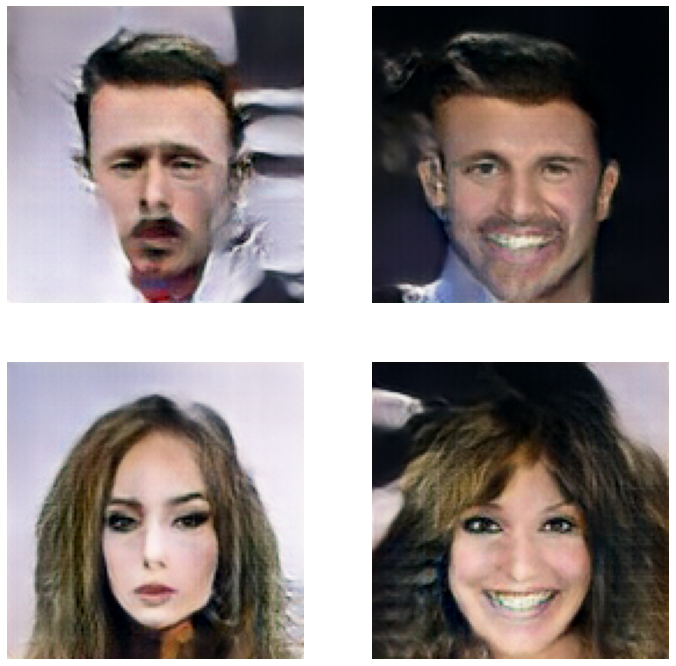

In [28]:
plt.figure(1, figsize=(12, 12))
# man without smile
plt.subplot(221)
img1 = generator.predict(create_latent_vector(male=1, smile=-1))[0]
plt.imshow(img1)
plt.axis('off')
# man with smile
plt.subplot(222)
img2 = generator.predict(create_latent_vector(male=1, smile=1))[0]
plt.imshow(img2)
plt.axis('off')
# woman without smile
plt.subplot(223)
img3 = generator.predict(create_latent_vector(male=-1, smile=-1))[0]
plt.imshow(img3)
plt.axis('off')
# woman with smile
plt.subplot(224)
img4 = generator.predict(create_latent_vector(male=-1, smile=1))[0]
plt.imshow(img4)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


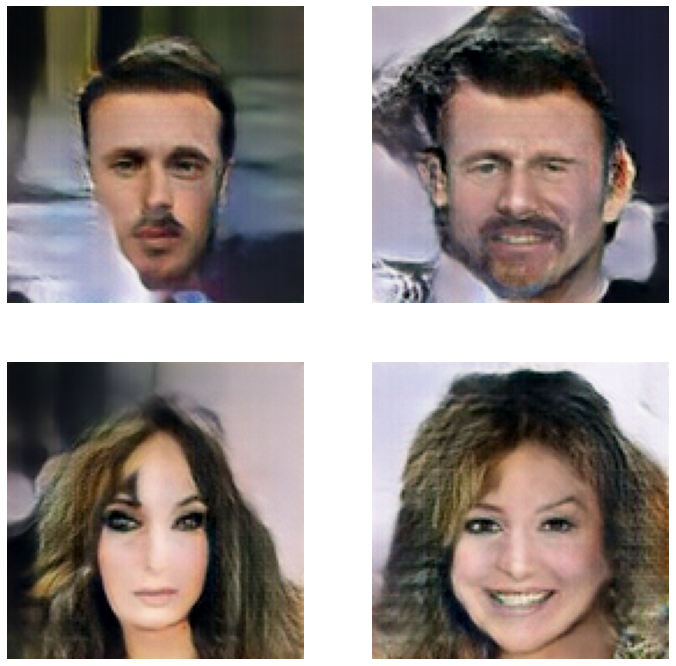

In [29]:
plt.figure(1, figsize=(12, 12))
# thin man
plt.subplot(221)
img1 = generator.predict(create_latent_vector(male=1, thickness=-1))[0]
plt.imshow(img1)
plt.axis('off')
# thick man
plt.subplot(222)
img2 = generator.predict(create_latent_vector(male=1, thickness=1))[0]
plt.imshow(img2)
plt.axis('off')
# thin woman
plt.subplot(223)
img3 = generator.predict(create_latent_vector(male=-1, thickness=-1))[0]
plt.imshow(img3)
plt.axis('off')
# thick woman
plt.subplot(224)
img4 = generator.predict(create_latent_vector(male=-1, thickness=1))[0]
plt.imshow(img4)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


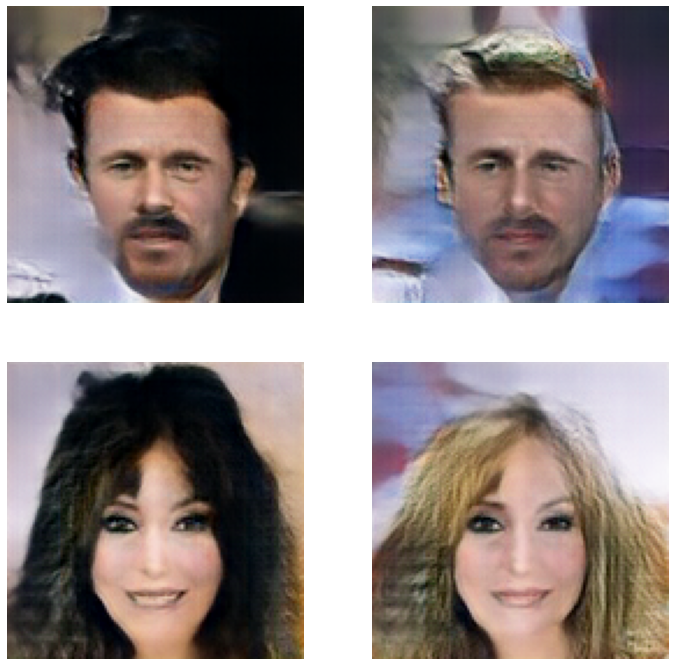

In [30]:
plt.figure(1, figsize=(12, 12))
# man with dark hair
plt.subplot(221)
img1 = generator.predict(create_latent_vector(male=1, light_hair=-1))[0]
plt.imshow(img1)
plt.axis('off')
# man with light hair
plt.subplot(222)
img2 = generator.predict(create_latent_vector(male=1, light_hair=1))[0]
plt.imshow(img2)
plt.axis('off')
# woman with dark hair
plt.subplot(223)
img3 = generator.predict(create_latent_vector(male=-1, light_hair=-1))[0]
plt.imshow(img3)
plt.axis('off')
# woman with light hair
plt.subplot(224)
img4 = generator.predict(create_latent_vector(male=-1, light_hair=1))[0]
plt.imshow(img4)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


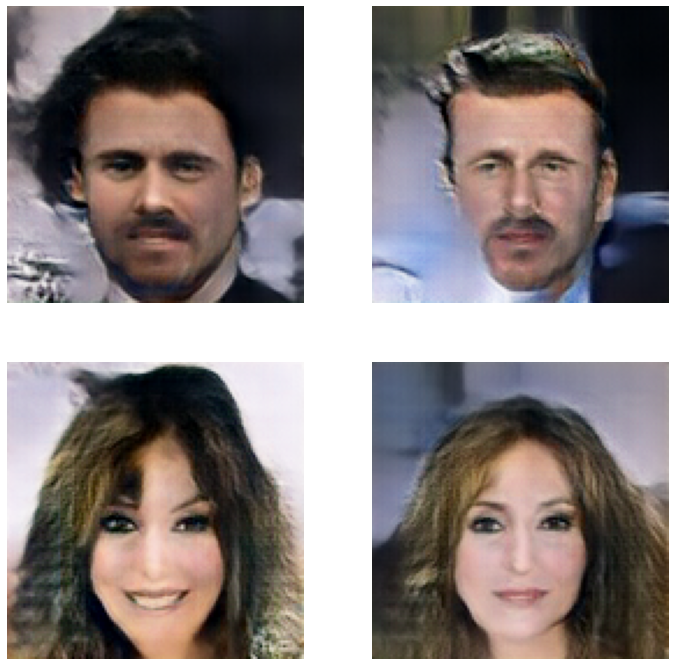

In [31]:
plt.figure(1, figsize=(12, 12))
# man with long hair
plt.subplot(221)
img1 = generator.predict(create_latent_vector(male=1, short_hair=-1))[0]
plt.imshow(img1)
plt.axis('off')
# man with short hair
plt.subplot(222)
img2 = generator.predict(create_latent_vector(male=1, short_hair=1))[0]
plt.imshow(img2)
plt.axis('off')
# woman with long hair
plt.subplot(223)
img3 = generator.predict(create_latent_vector(male=-1, short_hair=-1))[0]
plt.imshow(img3)
plt.axis('off')
# woman with short hair
plt.subplot(224)
img4 = generator.predict(create_latent_vector(male=-1, short_hair=1))[0]
plt.imshow(img4)
plt.axis('off')
plt.show()